In [ ]:
!wget https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip

In [3]:
!unzip /content/data_original.zip

Archive:  /content/data_original.zip
   creating: data_original/
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  


In [4]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


#Задание 3

In [5]:
import pandas as pd
import numpy as np
import numba as nb
import timeit

from rectools import Columns
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
np.random.seed(23)

In [7]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [8]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [9]:
top_k = 10
df, users, recs = generate_subsample(10000, top_k)

Pandas implementation:

In [10]:
def pandas_mrr(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    df_recs = df_recs.sort_values(by=[Columns.User, Columns.Rank])
    df_recs = df_recs.groupby(Columns.User).first().reset_index()
    mrr = (1 / df_recs['rank']).sum() / len(users)
    return mrr

In [11]:
print(f'MRR: {pandas_mrr(df, users, recs, top_k)}')

MRR: 0.07836801587301587


Naive implementation:

In [12]:
def naive_mrr(df, users, recs):
    target = df.values
    mrr = 0
    for i, user in enumerate(users):
        user_target = target[target[:, 0] == user][:, 1]
        for j, item in enumerate(recs[i], 1):
            if item not in user_target:
                continue
            else:
                mrr += 1 / j
                break
    return mrr / len(users)      

In [13]:
print(f'MRR: {naive_mrr(df, users, recs)}')

MRR: 0.07836801587301619


Numba implementation:

In [14]:
target = df.values

@nb.njit(cache=True, parallel=True)
def numba_mrr(target, users, recs):
    mrr = 0
    for i in nb.prange(len(users)):
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, item in enumerate(recs[i], 1):
            if item not in user_target:
                continue
            else:
                mrr += 1 / j
                break
    return mrr / len(users)

In [15]:
print(f'MRR: {numba_mrr(target, users, recs)}')

MRR: 0.07836801587301577


**Function comparison**

Time estimation:

In [16]:
user_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
n_times = 10
results = []

for i in user_count:
    for j in top_k:
        df, users, recs = generate_subsample(i, j)

        res_1 = timeit.timeit('naive_mrr(df, users, recs)', globals=globals(), number=n_times) #naive
        
        target = df.values
        res_2 = timeit.timeit('numba_mrr(target, users, recs)', globals=globals(), number=n_times) #numba

        res_3 = timeit.timeit('pandas_mrr(df, users, recs, j)', globals=globals(), number=n_times) #pandas

        results.append([i, j, {
            'naive': res_1,
            'numba': res_2,
            'pandas': res_3
        }])

Visualisation of results:

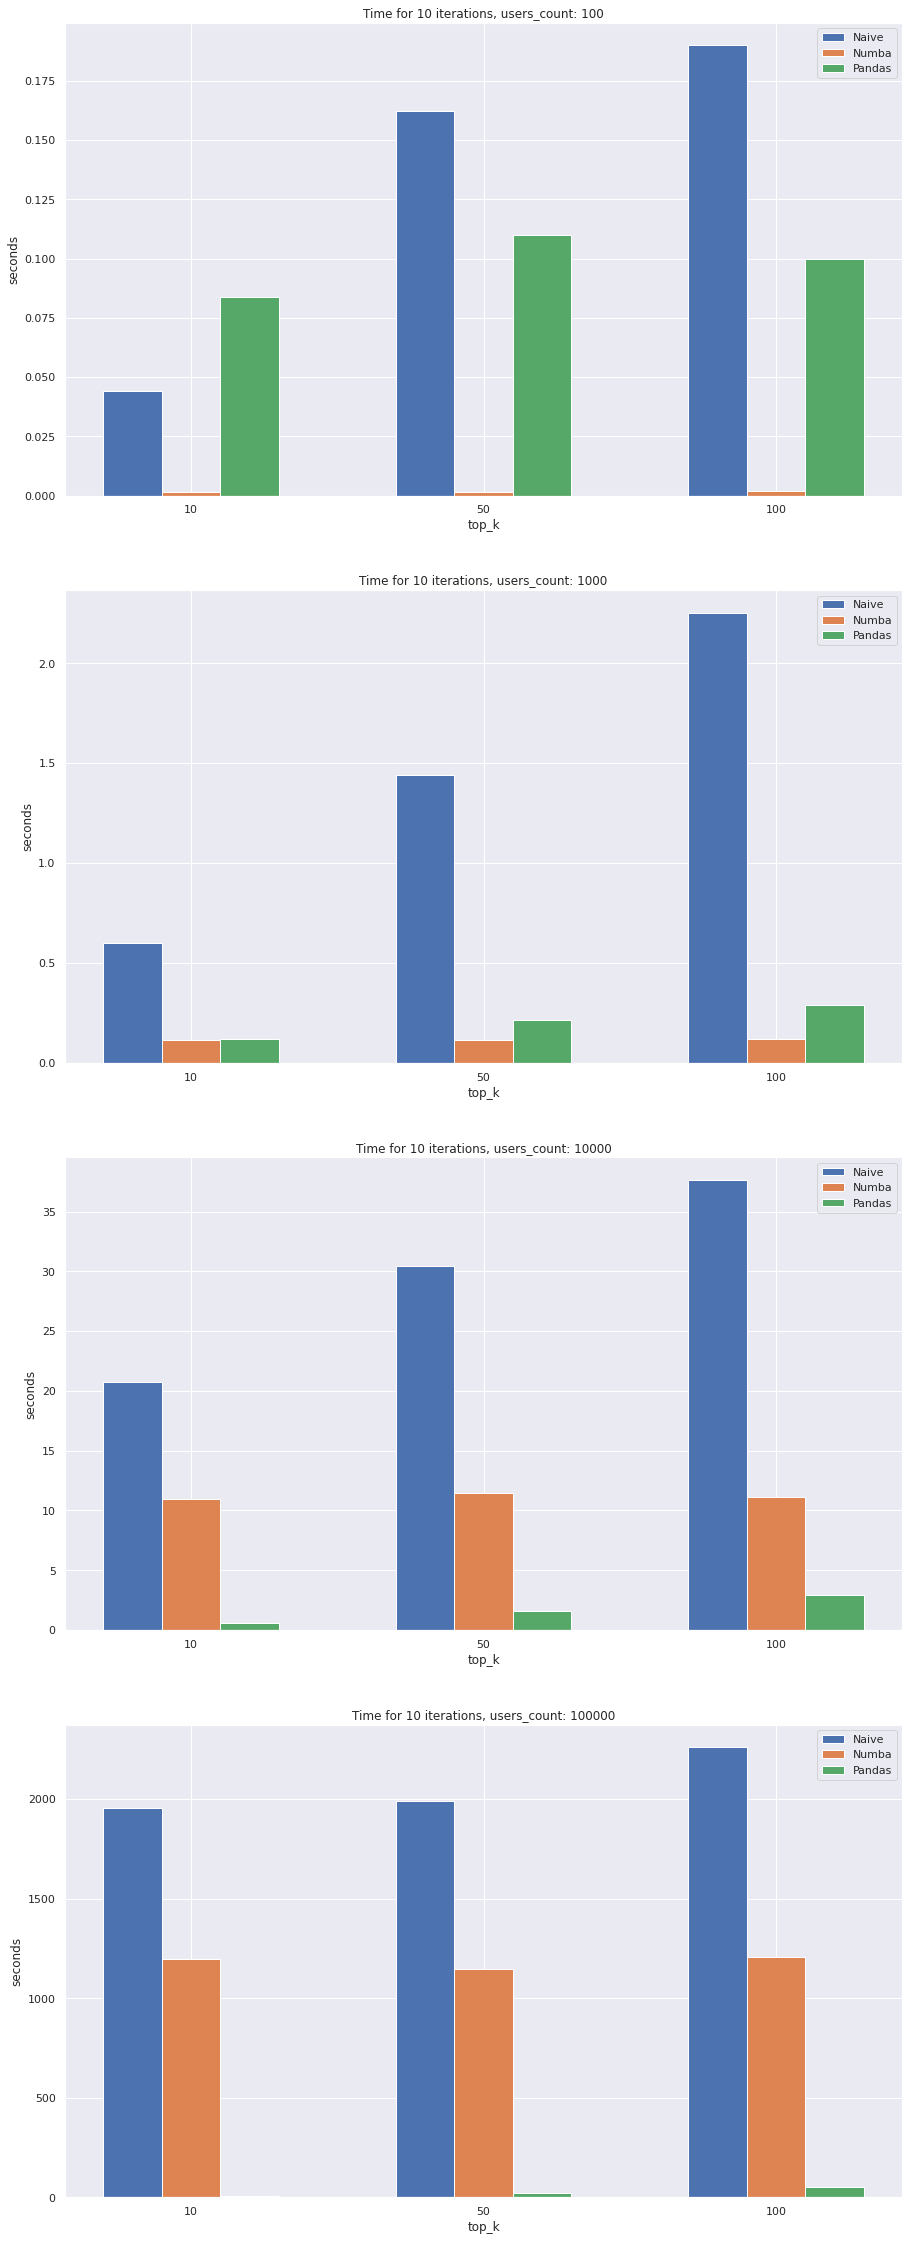

In [18]:
x = np.arange(3)
width = 0.20

f, ax = plt.subplots(4)
f.set_size_inches(15, 40)
k = 0

for i in range(4): #4

    res_1, res_2, res_3 = [], [], []
    for j in range(3):
        res_1.append(results[j + k][2]['naive'])
        res_2.append(results[j + k][2]['numba'])
        res_3.append(results[j + k][2]['pandas'])
    k += j + 1


    ax[i].bar(x - width, res_1, width, label='Naive')
    ax[i].bar(x, res_2, width, label='Numba' )
    ax[i].bar(x + width, res_3, width, label='Pandas')

    ax[i].set_ylabel('seconds')
    ax[i].set_xlabel('top_k')
    ax[i].set_title(f'Time for 10 iterations, users_count: {10 ** (i + 2)}')
    ax[i].xaxis.set_major_locator(FixedLocator([0, 1, 2]))
    ax[i].xaxis.set_major_formatter(FixedFormatter(['10', '50', '100']))
    ax[i].legend()
    
plt.grid(color='w')
plt.show()

## Вывод:

Как видно на графиках, при небольшом объеме выборки (100 и 1000) быстрее работает подсчет метрики с помощью Numba, ппри большем объеме выборки, быстрее справляется Pandas.